# Vessel Track Interpolation

## Defining the data transformation and the visualization functions

In [1]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

def track2dataframe(tracks):
    data = []
    # Iterate over each track in the vessels_generator
    for track in tracks:
        # Unpack static information
        mmsi = track['mmsi']
        # Unpack dynamic information
        times = track['time']
        lons = track['lon']
        lats = track['lat']
    
        # Iterate over the dynamic arrays and create a row for each time point
        for i in range(len(times)):
            data.append({
                'mmsi': mmsi,
                'time': times[i],
                'longitude': lons[i],
                'latitude': lats[i],
            })
            
    # Convert the list of dictionaries to a pandas DataFrame
    df = pd.DataFrame(data)
    
    return df

def plotly_visualize(data, visual_type='lines'):
    if (visual_type=='scatter'):
        # Create a scatter plot for the vessel data points using scatter_geo
        fig = px.scatter_geo(
            data,
            lat="latitude",
            lon="longitude",
            color="mmsi",  # Color by vessel identifier
            hover_name="mmsi",
            hover_data={"time": True},
            title="Vessel Data Points"
        )
    else:
        # Create a line plot for the vessel trajectory using line_geo
        fig = px.line_geo(
            data,
            lat="latitude",
            lon="longitude",
            color="mmsi",  # Color by vessel identifier
            hover_name="mmsi",
            hover_data={"time": True},
            title="Vessel Trajectory"
        )
    
    # Set the map style and projection
    fig.update_geos(
        projection_type="azimuthal equal area",  # Change this to 'natural earth', 'azimuthal equal area', etc.
        showland=True,
        landcolor="rgb(243, 243, 243)",
        countrycolor="rgb(204, 204, 204)",
    )
    
    # Set the layout to focus on a specific area or zoom level
    fig.update_layout(
        geo=dict(
            projection_type="azimuthal equal area",
        ),
        width=1200,  # Increase the width of the plot
        height=800,  # Increase the height of the plot
    )
    
    fig.show()

## Original track

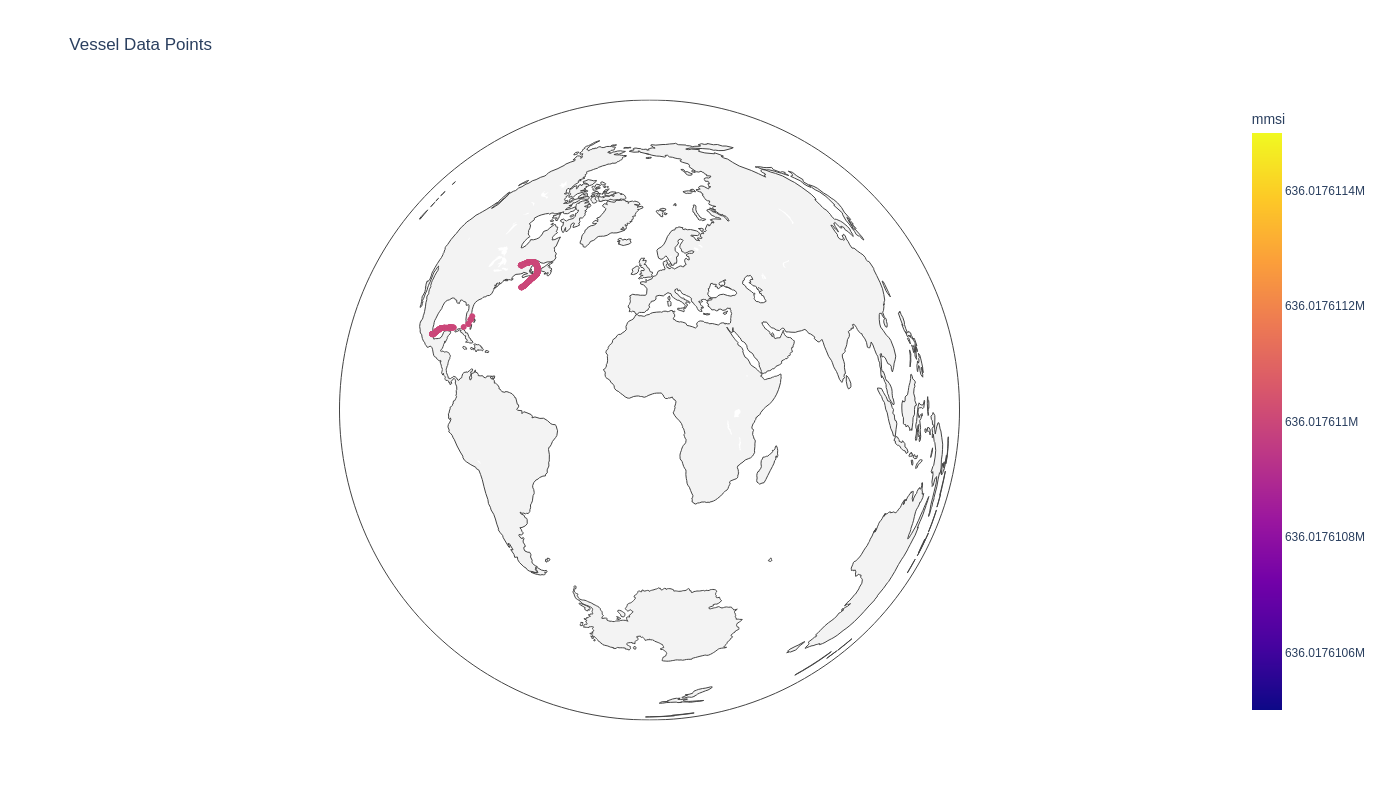

In [2]:
import numpy as np
import aisdb
from aisdb import DBConn, DBQuery
from datetime import timedelta, datetime
import nest_asyncio
nest_asyncio.apply()

# dbpath='YOUR_DATABASE.db' # Define the path to your database
dbpath='../data/meridian_2018_vacuumed.db'

MMSI = 636017611 # MMSI of the vessel

# Set the start and end times for the query
start_time = datetime.strptime("2018-03-10 00:00:00", '%Y-%m-%d %H:%M:%S')
end_time = datetime.strptime("2018-03-31 00:00:00", '%Y-%m-%d %H:%M:%S')

with aisdb.SQLiteDBConn(dbpath=dbpath) as dbconn:
    qry = aisdb.DBQuery(
        dbconn=dbconn,
        start=start_time,
        end=end_time,
        mmsi = MMSI,
        callback=aisdb.database.sqlfcn_callbacks.in_timerange_hasmmsi,
    )
    rowgen = qry.gen_qry()
    tracks = aisdb.track_gen.TrackGen(rowgen, decimate=False)
    
    # Visualize the original track data points
    df = track2dataframe(tracks)
    plotly_visualize(df, 'scatter')

## Linear Interpolation

### Equal Time Window

This method estimates the position of a vessel at regular time intervals (e.g., every 10 minutes). 

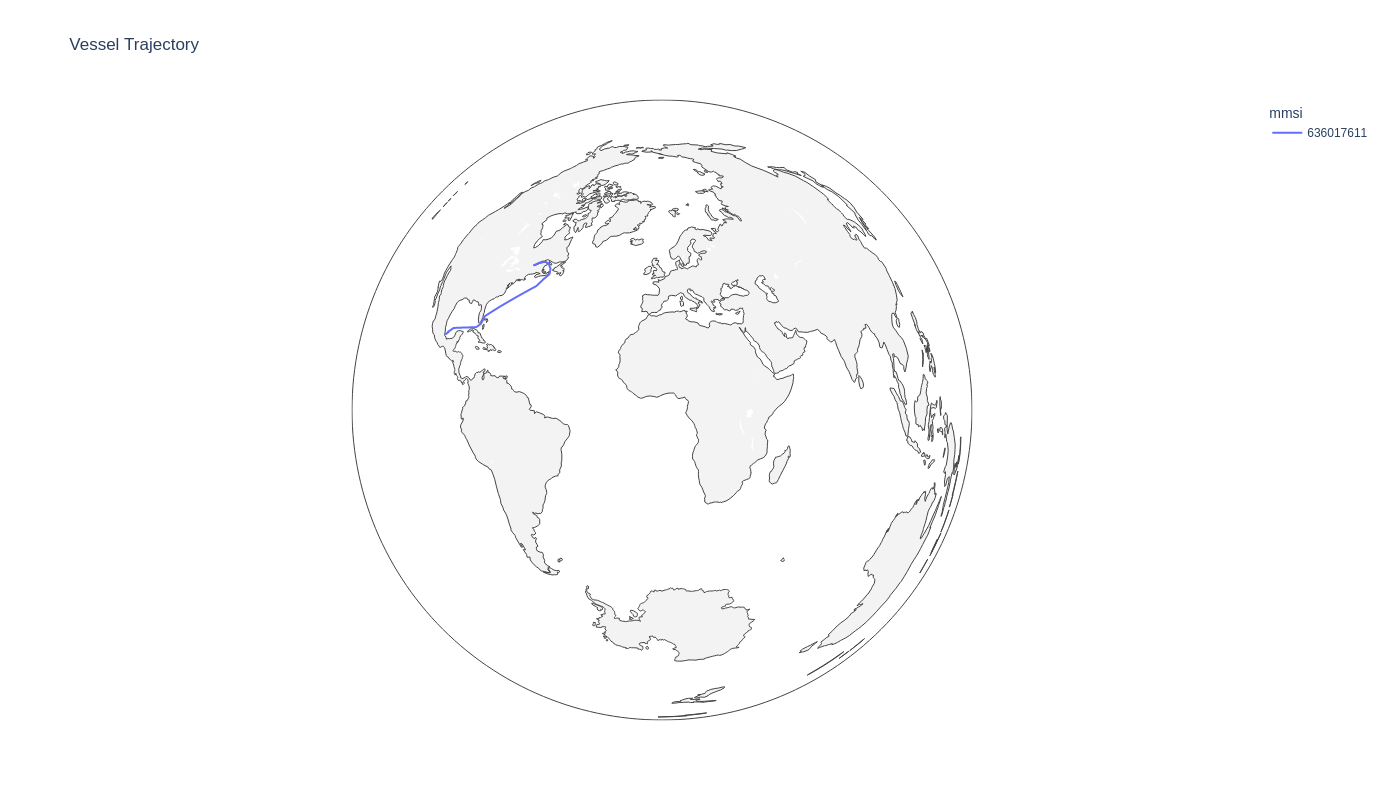

In [3]:
with aisdb.SQLiteDBConn(dbpath=dbpath) as dbconn:
    qry = aisdb.DBQuery(
        dbconn=dbconn,
        start=start_time,
        end=end_time,
        mmsi = MMSI,
        callback=aisdb.database.sqlfcn_callbacks.in_timerange_hasmmsi,
    )
    rowgen = qry.gen_qry()
    tracks = aisdb.track_gen.TrackGen(rowgen, decimate=False)

    tracks__ = aisdb.interp.interp_time(tracks, timedelta(minutes=10))

    df = track2dataframe(tracks__)
    plotly_visualize(df)

### Equal Distance Intervals

This method estimates the position of a vessel at regular spatial intervals (e.g., every 1 km along its path).

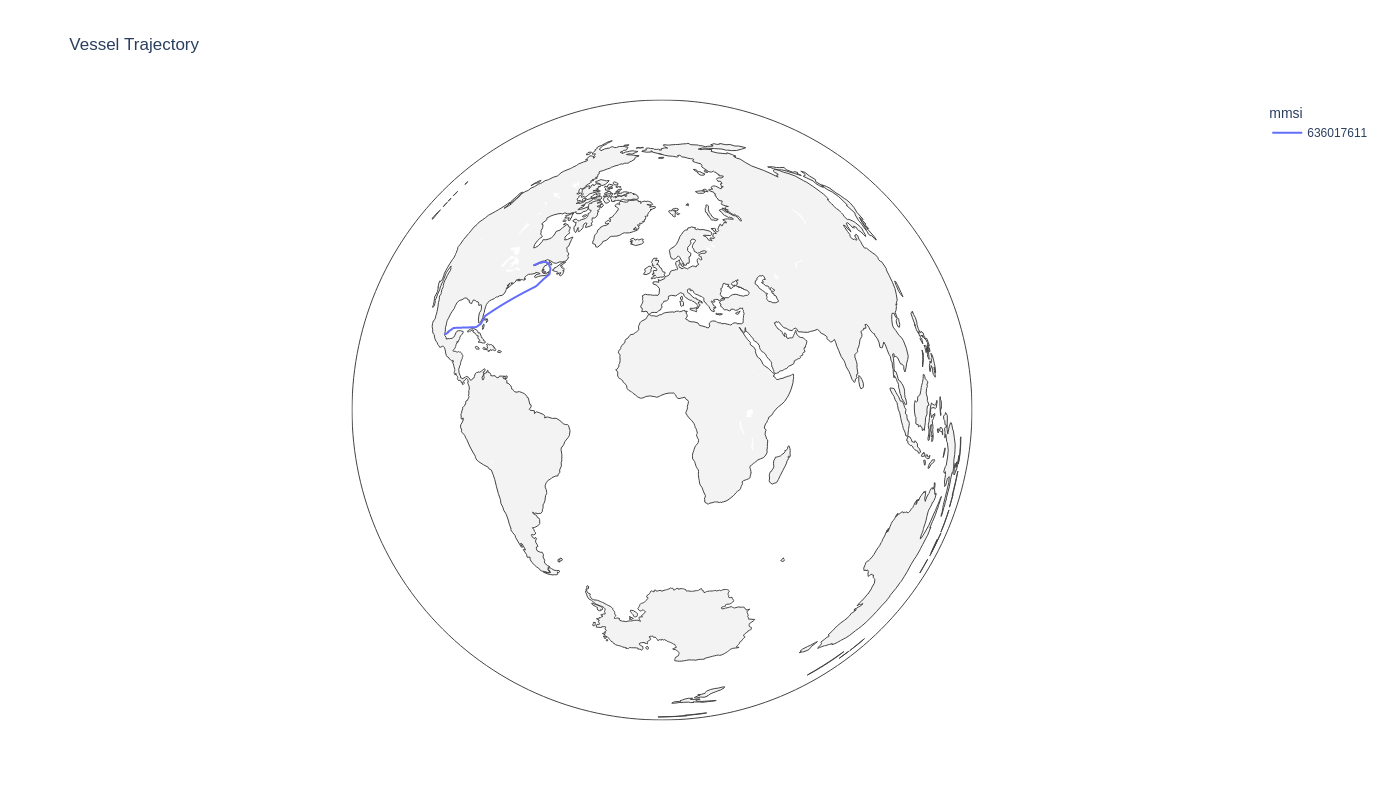

In [4]:
with aisdb.SQLiteDBConn(dbpath=dbpath) as dbconn:
    qry = aisdb.DBQuery(
        dbconn=dbconn,
        start=start_time,
        end=end_time,
        mmsi = MMSI,
        callback=aisdb.database.sqlfcn_callbacks.in_timerange_hasmmsi,
    )
    rowgen = qry.gen_qry()
    tracks = aisdb.track_gen.TrackGen(rowgen, decimate=False)

    tracks__ = aisdb.interp.interp_spacing(spacing=500, tracks=tracks)

    # Visualizing the tracks
    df = track2dataframe(tracks__)
    plotly_visualize(df)

### Geodesic Track Interpolation

This method estimates the positions of a vessel along a curved path using the principles of geometry, particularly involving great-circle routes. 

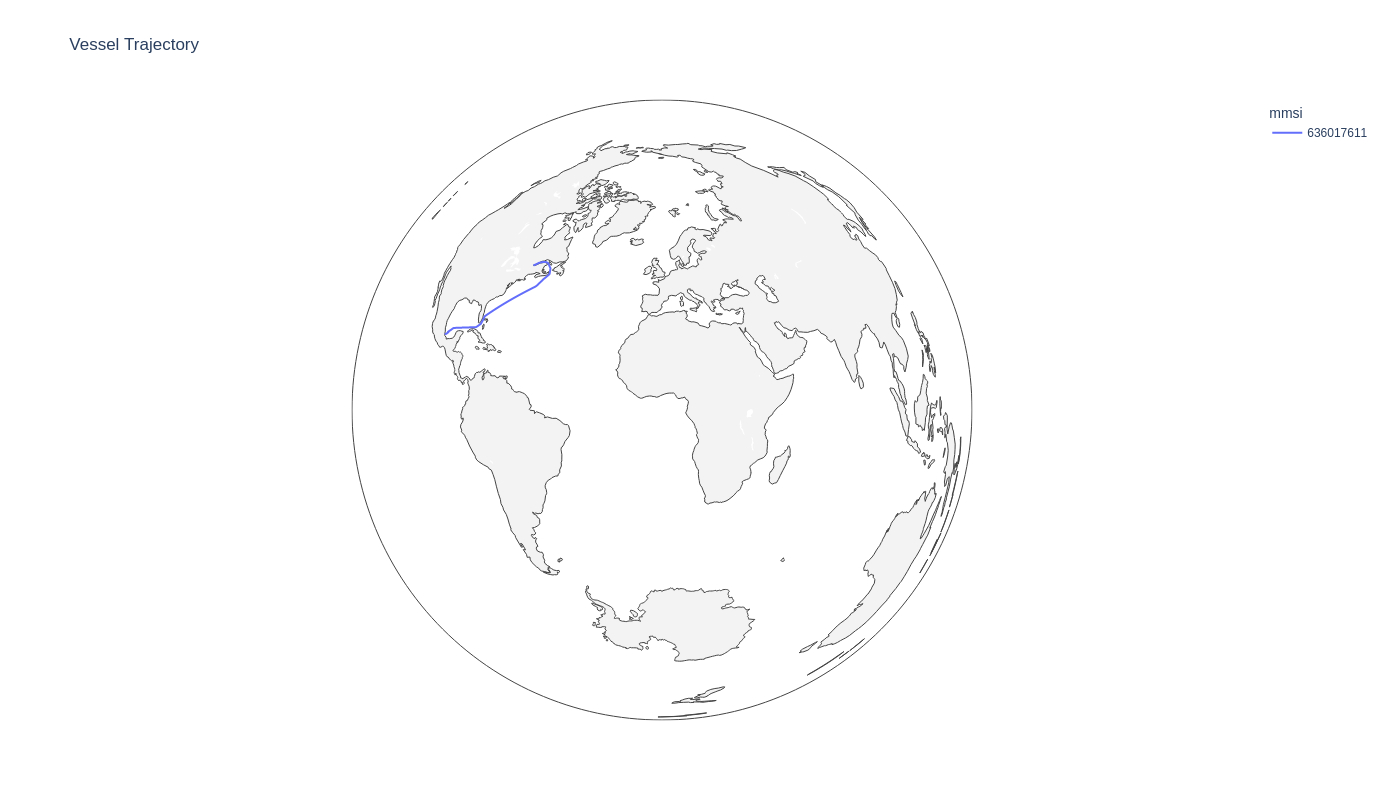

In [5]:
with aisdb.SQLiteDBConn(dbpath=dbpath) as dbconn:
    qry = aisdb.DBQuery(
        dbconn=dbconn,
        start=start_time,
        end=end_time,
        mmsi = MMSI,
        callback=aisdb.database.sqlfcn_callbacks.in_timerange_hasmmsi,
    )
    rowgen = qry.gen_qry()
    tracks = aisdb.track_gen.TrackGen(rowgen, decimate=False)

    tracks__ = aisdb.interp.geo_interp_time(tracks, timedelta(minutes=10))

    df = track2dataframe(tracks__)
    plotly_visualize(df)

## Cubic Spline Interpolation

Given a set of data points, cubic spline interpolation fits a smooth curve through these points. The curve is represented as a series of cubic polynomials between each pair of data points. Each polynomial ensures a smooth curve at the data points (i.e., the first and second derivatives are continuous).

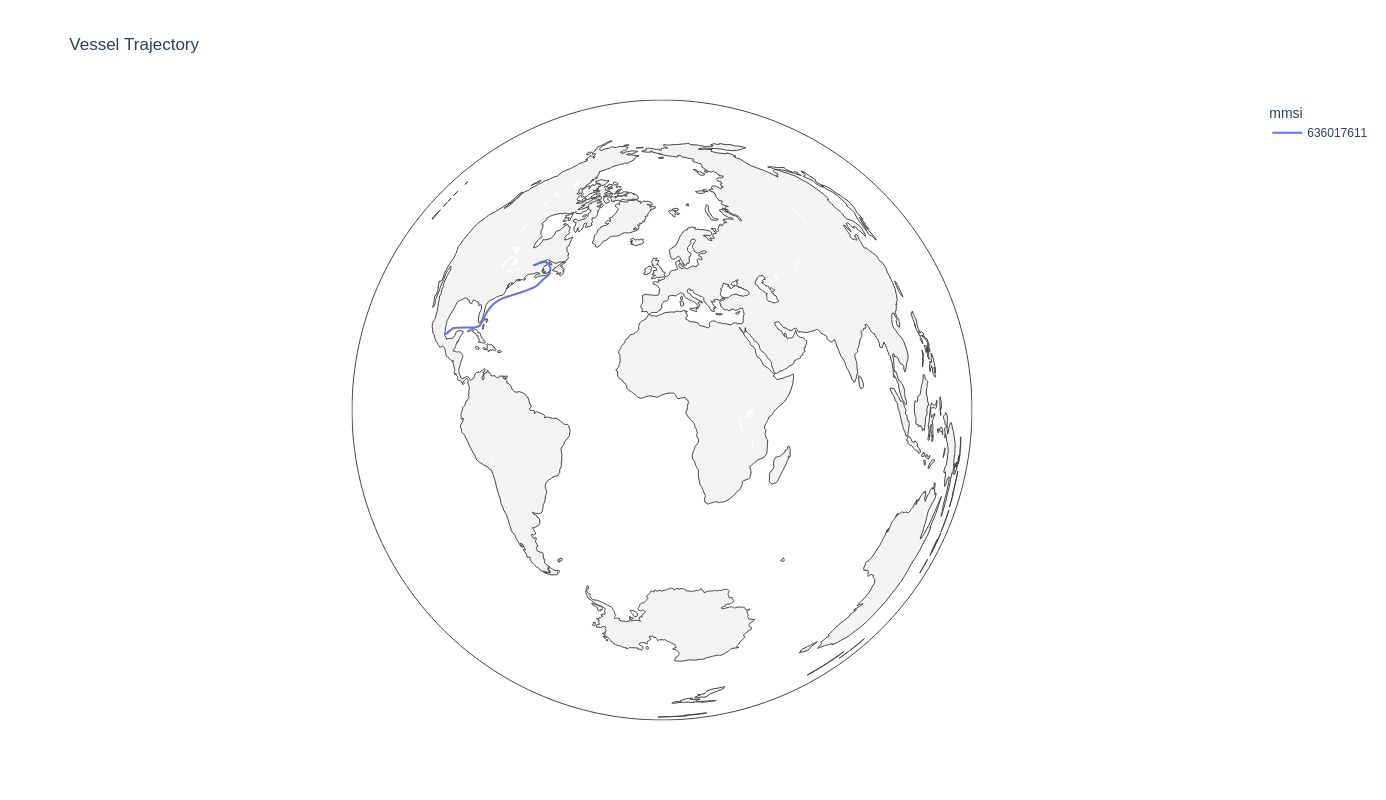

In [6]:
with aisdb.SQLiteDBConn(dbpath=dbpath) as dbconn:
    qry = aisdb.DBQuery(
        dbconn=dbconn,
        start=start_time,
        end=end_time,
        mmsi = MMSI,
        callback=aisdb.database.sqlfcn_callbacks.in_timerange_hasmmsi,
    )
    rowgen = qry.gen_qry()
    tracks = aisdb.track_gen.TrackGen(rowgen, decimate=False)

    tracks__ = aisdb.interp.interp_cubic_spline(tracks, timedelta(minutes=10))

    # Visualizing the tracks
    df = track2dataframe(tracks__)
    plotly_visualize(df)

## Custom Track Interpolation

Example of B-Spline:

In [17]:
import numpy as np
from scipy.interpolate import splrep, splev

def bspline_interpolation(track, key, intervals):
    """
    Perform B-Spline interpolation for a specific key on the track data.

    Parameters:
    - track: Dictionary containing vessel track data (time, lat, lon, etc.).
    - key: The dynamic key (e.g., 'lat', 'lon') for which interpolation is performed.
    - intervals: The equal time intervals or distance intervals at which interpolation is required.

    Returns:
    - Interpolated values for the specified key.
    """
    # Get time and the key values (e.g., lat/lon) for interpolation
    times = track['time']
    values = track[key]

    # Create the B-Spline representation of the curve
    tck = splrep(times, values, s=0)  # s=0 means no smoothing, exact fit to data

    # Interpolate the values at the given intervals
    interpolated_values = splev(intervals, tck)

    return interpolated_values

def interp_bspline(tracks, step=1000):
    """
    Perform B-Spline interpolation on vessel trajectory data at equal time intervals.

    Parameters:
    - tracks: List of vessel track dictionaries.
    - step: Step for interpolation (can be time or distance based).

    Yields:
    - Dictionary containing interpolated lat and lon values for each track.
    """
    for track in tracks:
        if len(track['time']) <= 1:
            warnings.warn('Cannot interpolate track of length 1, skipping...')
            continue

        # Generate equal time intervals based on the first and last time points
        intervals = np.arange(track['time'][0], track['time'][-1], step)

        # Perform B-Spline interpolation for lat and lon
        interpolated_lat = bspline_interpolation(track, 'lat', intervals)
        interpolated_lon = bspline_interpolation(track, 'lon', intervals)

        # Yield interpolated track
        itr = dict(
            mmsi=track['mmsi'],
            lat=interpolated_lat,
            lon=interpolated_lon,
            time=intervals  # Including interpolated time intervals for reference
        )
        yield itr

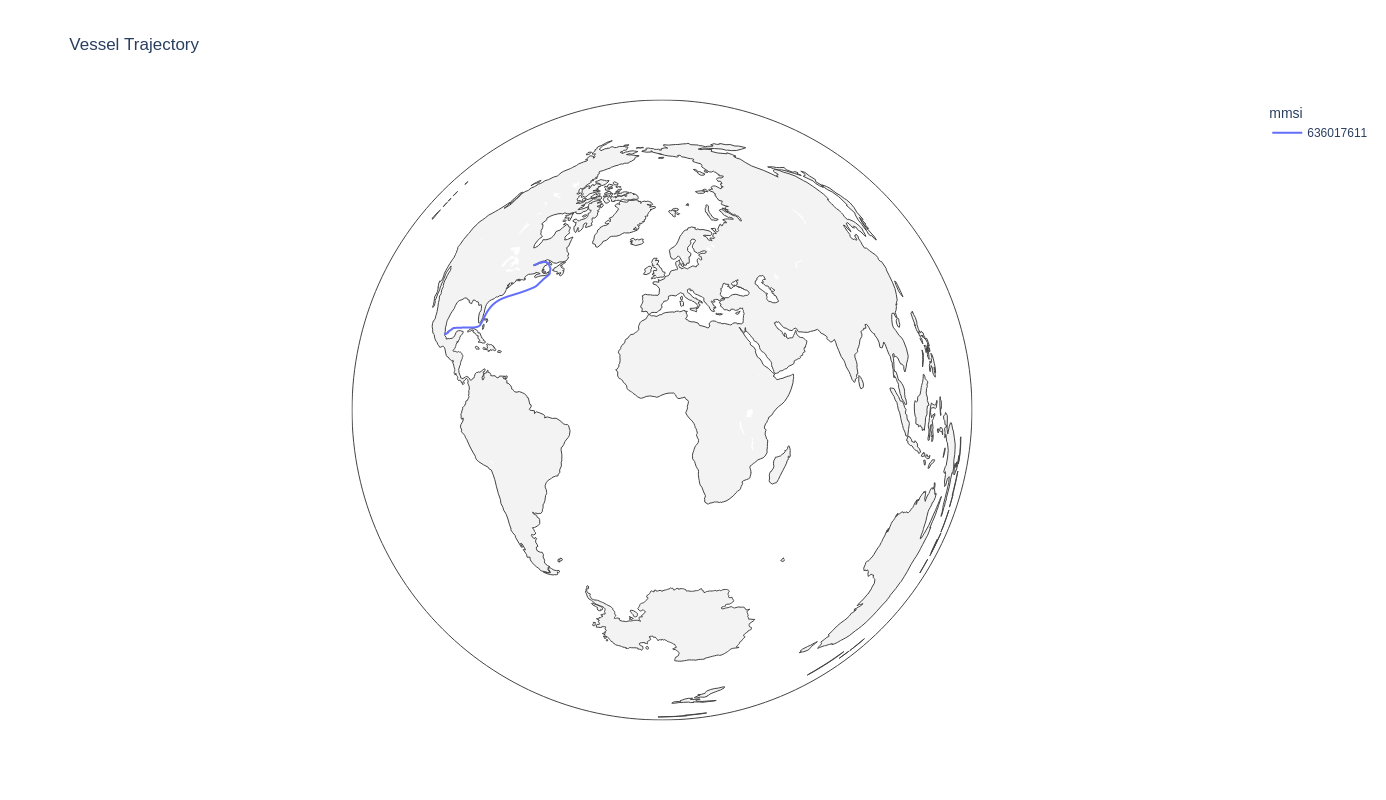

In [18]:
with aisdb.SQLiteDBConn(dbpath=dbpath) as dbconn:
    qry = aisdb.DBQuery(
        dbconn=dbconn,
        start=start_time,
        end=end_time,
        mmsi = MMSI,
        callback=aisdb.database.sqlfcn_callbacks.in_timerange_hasmmsi,
    )
    rowgen = qry.gen_qry()
    tracks = aisdb.track_gen.TrackGen(rowgen, decimate=False)

    tracks__ = interp_bspline(tracks)

    # Visualizing the tracks
    df = track2dataframe(tracks__)
    plotly_visualize(df)